In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-and-test/train.csv
/kaggle/input/train-and-test/test.csv



# DemandEdge - Advanced Demand Forecasting

### Introduction

DemandEdge is a robust forecasting platform designed to address complex business forecasting needs, 
using state-of-the-art predictive models. In this notebook, we delve into the application of 
**SARIMA** and **ARIMA** models to predict store-item demand. These models play a crucial role in 
ensuring accurate demand forecasting, enabling businesses to optimize inventory and improve supply chain management.

Key Highlights:
- **SARIMA/ARIMA** models capture seasonality and trends effectively.
- Applications span retail, e-commerce, and manufacturing sectors.
- Comparative insights with other models like **XGBoost** ensure optimal decision-making.

This notebook showcases how time series modeling aligns with DemandEdge's objectives to provide reliable, actionable insights for better business outcomes.


## Objectives

1. Leverage SARIMA/ARIMA for accurate demand forecasting.
2. Analyze sales patterns for 50 items across 10 stores over 5 years.
3. Assess the performance of classical models against machine learning approaches.
4. Provide actionable insights for inventory and supply chain optimization.


## 1. Import Libraries & Data

In [24]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

import pickle

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_style('whitegrid')

import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=ValueError)

from statsmodels.tools.sm_exceptions import ConvergenceWarning, InterpolationWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', InterpolationWarning)

sns.set_style('whitegrid')
colors = sns.color_palette('tab10')

pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

## Dataset Description

The dataset contains historical daily sales data for 50 items across 10 stores from 2013 to 2017. Key features include:

- **date**: The date of the sales record.
- **store**: Unique identifier for each store.
- **item**: Unique identifier for each item.
- **sales**: The number of items sold.

### Dataset Insights:
- The dataset spans 5 years, offering rich temporal patterns.
- Seasonal trends and store-level differences are critical for forecasting accuracy.


In [25]:
train = pd.read_csv('/kaggle/input/train-and-test/train.csv', 
                    parse_dates = ['date'])

train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


### Data Cleaning

In [27]:
# Reduce memory usage
# train[['store', 'item']] = train[['store', 'item']].astype('category')
train['store'] =  pd.to_numeric(train['store'], downcast='integer')
train['item'] =  pd.to_numeric(train['item'], downcast='integer')
train['sales'] = pd.to_numeric(train['sales'], downcast='integer')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int8          
 2   item    913000 non-null  int8          
 3   sales   913000 non-null  int16         
dtypes: datetime64[ns](1), int16(1), int8(2)
memory usage: 10.4 MB


In [28]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [29]:
train.describe()

,date,store,item,sales
count,913000,"913,000.00","913,000.00","913,000.00"
mean,2015-07-02 11:59:59.999999744,5.50,25.50,52.25
min,2013-01-01 00:00:00,1.00,1.00,0.00
25%,2014-04-02 00:00:00,3.00,13.00,30.00
50%,2015-07-02 12:00:00,5.50,25.50,47.00
75%,2016-10-01 00:00:00,8.00,38.00,70.00
max,2017-12-31 00:00:00,10.00,50.00,231.00
std,NaN,2.87,14.43,28.80


In [30]:
test = pd.read_csv('/kaggle/input/train-and-test/test.csv', 
                   parse_dates = ['date'])

test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [31]:
# Reduce memory usage
# test[['store', 'item']] = test[['store', 'item']].astype('category')
test['store'] =  pd.to_numeric(test['store'], downcast='integer')
test['item'] =  pd.to_numeric(test['item'], downcast='integer')

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int8          
 3   item    45000 non-null  int8          
dtypes: datetime64[ns](1), int64(1), int8(2)
memory usage: 791.1 KB


In [32]:
test.isnull().sum()

id       0
date     0
store    0
item     0
dtype: int64

In [33]:
test.describe()

,id,date,store,item
count,"45,000.00",45000,"45,000.00","45,000.00"
mean,"22,499.50",2018-02-14 12:00:00.000000256,5.50,25.50
min,0.00,2018-01-01 00:00:00,1.00,1.00
25%,"11,249.75",2018-01-23 00:00:00,3.00,13.00
50%,"22,499.50",2018-02-14 12:00:00,5.50,25.50
75%,"33,749.25",2018-03-09 00:00:00,8.00,38.00
max,"44,999.00",2018-03-31 00:00:00,10.00,50.00
std,"12,990.53",NaN,2.87,14.43


## 2. Data Preprocessing

In [34]:
# Convert 'date' to datetime format
# train['date'] = pd.to_datetime(train['date'])
# test['date'] = pd.to_datetime(test['date'])

train.set_index('date', inplace=True)

train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


### EDA
## Sales Distribution and Outlier Analysis (Before Removal)

To better understand the distribution of sales and identify potential outliers, we plot:

1. **Histogram**: Displays the overall distribution of sales data.
2. **Boxplot**: Highlights outliers and provides a visual summary of the sales data distribution.

These plots help us determine if outlier removal is necessary to improve model performance.


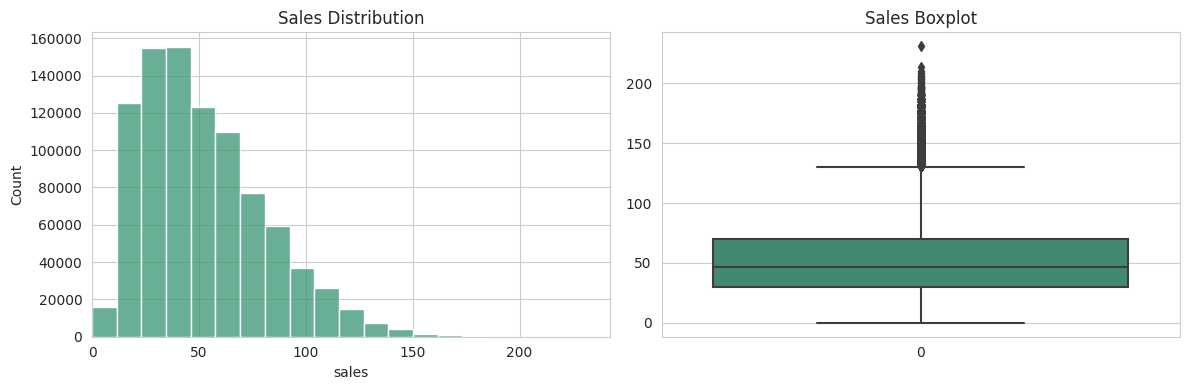

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12, 4))

sns.histplot(train['sales'], bins=20, ax=ax1, color='#369572')
ax1.set_title('Sales Distribution')
ax1.set_xlim(train['sales'].min())
sns.boxplot(train['sales'], ax=ax2, color='#369572')

ax2.set_title('Sales Boxplot')
# ax2.set_xlim(train['sales'].min())

plt.tight_layout()
plt.show()

## Outlier Removal

Outliers can significantly impact the performance of predictive models. To mitigate this, we remove data points where sales exceed the 98th percentile of the distribution. This threshold ensures that we retain most of the data while excluding extreme values.


In [36]:
# Remove outliers
train = train[train['sales'] < 
                    train['sales'].quantile(q = 0.98)]
train.describe()

,store,item,sales
count,"894,353.00","894,353.00","894,353.00"
mean,5.50,25.54,50.47
std,2.86,14.49,26.22
min,1.00,1.00,0.00
25%,3.00,13.00,29.00
50%,6.00,26.00,46.00
75%,8.00,38.00,68.00
max,10.00,50.00,123.00


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 894353 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   894353 non-null  int8 
 1   item    894353 non-null  int8 
 2   sales   894353 non-null  int16
dtypes: int16(1), int8(2)
memory usage: 10.2 MB


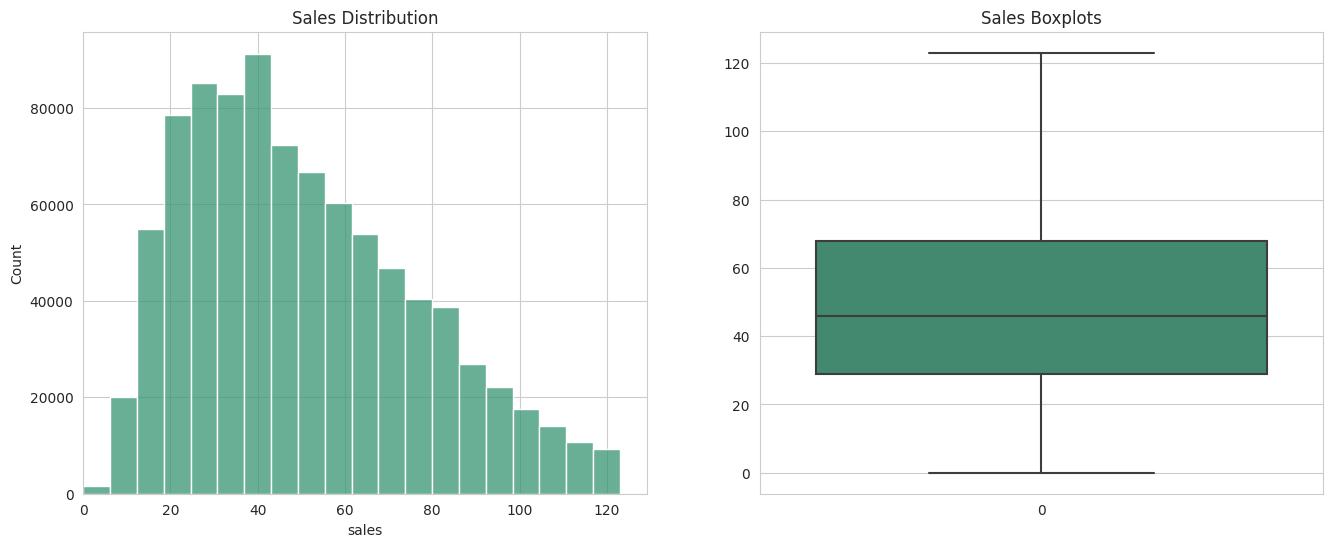

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16, 6))

sns.histplot(x=train['sales'], bins=20, ax=ax1, color='#369572')

ax1.set_title('Sales Distribution')
ax1.set_xlim(train['sales'].min())

sns.boxplot(train['sales'], ax=ax2, color='#369572')
ax2.set_title('Sales Boxplots')
# ax2.set_xlim(train['sales'].min())

plt.show()

## Sales Distribution and Outlier Analysis (After Removal)

After removing outliers, we replot the:

1. **Histogram**: Displays the revised sales distribution.
2. **Boxplot**: Confirms that extreme outliers have been excluded.

These plots show a cleaner dataset, ready for modeling with reduced skewness and more robust insights.


## 2.2 Smoothening the Data Using Differencing and Moving Average

### Description
Time series data often contains noise, trends, and seasonality, which can obscure meaningful patterns. To address this, we preprocess the data using:

1. **First-order Differencing**:
   - Removes linear trends and stabilizes the mean of the series.
   - Makes the data stationary, which is crucial for applying statistical models.

2. **Moving Average**:
   - Smooths the series by averaging sales over a 7-day window.
   - Highlights long-term patterns while reducing the impact of random fluding to weekly or yearly cycles.


In [39]:
# First-order differencing
differenced_train = train['sales'].diff()

# Rolling averages
rolling_average_train = train['sales'].rolling(window=7).mean()

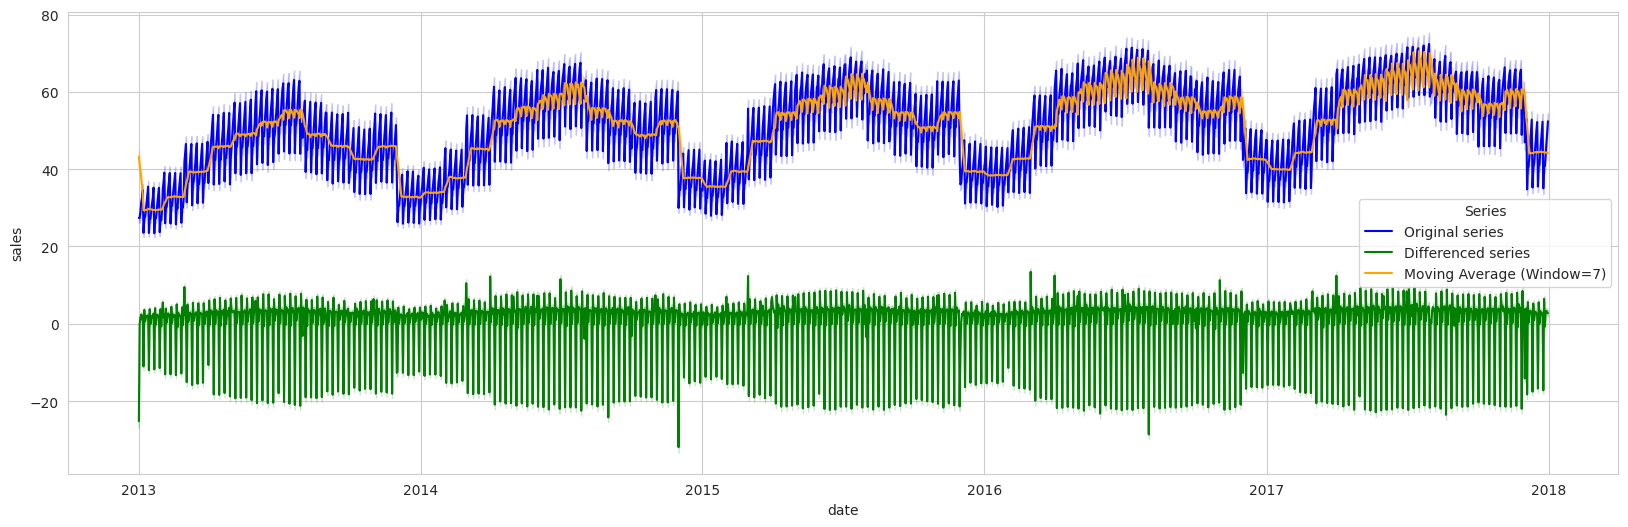

In [40]:
plt.figure(figsize=(20, 6))

# Plot the original series
sns.lineplot(data=train, x='date', y='sales', 
             color='blue', label='Original series')

# Plot the differenced series
sns.lineplot(x=differenced_train.index, y=differenced_train.values, 
             color='green', label='Differenced series')

# Plot the moving average series
sns.lineplot(x=rolling_average_train.index, y=rolling_average_train.values, 
             color='orange', label='Moving Average (Window=7)')

# Add the legend once after all the plots
plt.legend(title='Series')

plt.show()


### Observations

1. **Original Series**:
   - Exhibits clear seasonal trends with periodic peaks and troughs.
   - The sales data is non-stationary with an upward trend over time.

2. **Differenced Series**:
   - Shows fluctuations around zero, indicating that the trend component has been effectively removed.
   - Short-term variations are more pronounced.

3. **Moving Average Series**:
   - Smoothens the data by averaging over 7 days.
   - Reveals seasonal patterns while reducing random noise in the original data.

---

### Key Insights

1. The original series highlights clear seasonality in sales patterns, possibly corresponding to weekly or yearly cycles.


## 3. Plot the Autocorrelation

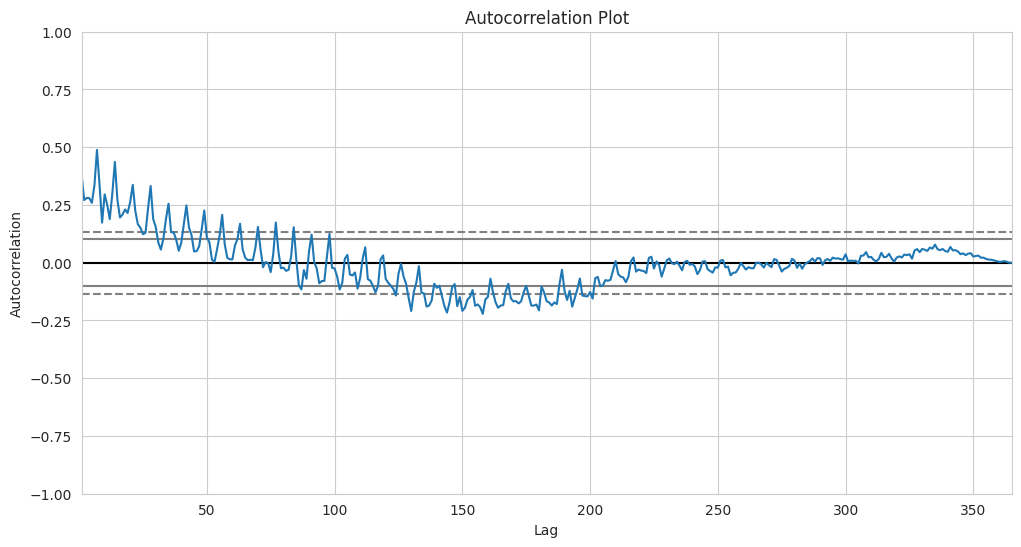

In [41]:
# Autocorrelation Plot
plt.figure(figsize=(12, 6))

autocorrelation_plot(train['sales'].values[:365])

plt.title('Autocorrelation Plot')
plt.grid()
plt.show()

The ACF plot exhibits a sinusoidal pattern.   

This is a strong indication of seasonality in our time series data.    
The repeating peaks and troughs suggest a cyclical pattern, likely related to seasonal factors.

`Key observations from the plot:`

- `Cyclic pattern:`    
    The ACF values oscillate between positive and negative, suggesting a cyclical relationship between the current value and past values.   
- `Decaying amplitude:`   
    The peaks and troughs gradually become smaller, indicating that the influence of past values on the current value decreases over time.
- `Significant lags:`    
    The ACF values are significant (outside the confidence bands) at lags that are multiples of a certain period (likely 12 months,    
    based on the context of our data). This confirms the seasonal pattern.

Based on this ACF plot, we might consider using a Seasonal ARIMA (SARIMA) model to capture both the seasonal component and    
any other trends or autoregressive/moving average components in our data.   

## 4. Stationarity Check

### 4.1 ADF test

ADF test is used to determine the presence of unit root in the series, and hence helps in understand if    
the series is stationary or not. The null and alternate hypothesis of this test are:

- Null Hypothesis: The series has a unit root.
- Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

In [42]:
# Set maxlag to 10 to reduce the dataset size
result = adfuller(train['sales'], maxlag=10)  

print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')
print('Critical Values: ', result[4])

ADF Statistic: -36.899
p-value: 0.000
Critical Values:  {'1%': -3.4303573118770774, '5%': -2.861543231766745, '10%': -2.566771720150838}


### Summary

p-value (0.0000) is lesser than the significance level (0.05), we reject the null hypothesis.   
The test suggests that the data is stationary.

### 4.2 KPSS test

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for    
the KPSS test are opposite that of the ADF test.

- Null Hypothesis: The process is trend stationary.
- Alternate Hypothesis: The series has a unit root (series is not stationary).

In [43]:
# KPSS Test
result = kpss(train['sales'])

print(f'KPSS Statistic: {result[0]:.3f}')
print('p-value:', result[1])
print('Critical Values:', result[3])

KPSS Statistic: 3.633
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


### Summary

p-value (0.01) is lesser than the significance level (0.05), we reject the null hypothesis.   
The test suggests that the data is non-stationary.

Based upon the significance level of 0.05 and the p-value:

- **ADF test:** The null hypothesis is rejected. Hence, the series is stationary
- **KPSS test:** There is evidence for rejecting the null hypothesis in favour of the alternative.    
    Hence, the series is non-stationary as per the KPSS test.

The discrepancy between the ADF and KPSS test suggests that the time series might contain a deterministic trend. 

To address this, we should:

- Consider differencing the series to achieve stationarity,
- Detrend the series if a trend is visually apparent,
- Re-check stationarity after applying transformations.

## 5. Plot ACF & PACF

When analyzing a time series, we should plot ACF and PACF plots before using seasonal decomposition: 

`ACF and PACF plots`

These plots help identify the most important lags to include in a time series model, and whether there are seasonal patterns in the data.

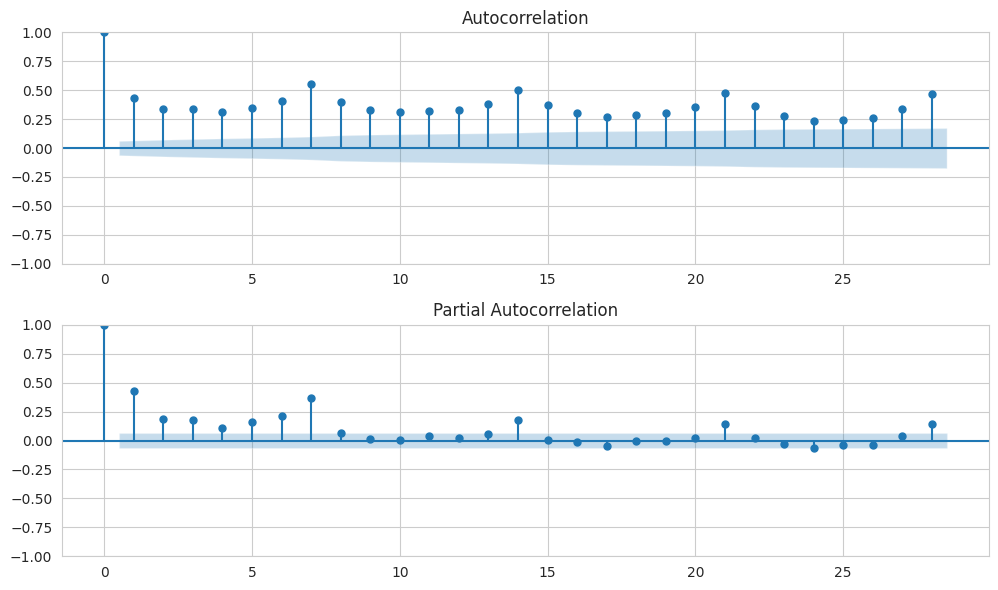

In [44]:
# Plot ACF and PACF Before Removing Seasonality:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# plt.subplot(121)
plot_acf(train.sales[:1000], lags=28, ax=axes[0])

# plt.subplot(122)
plot_pacf(train.sales[:1000], lags=28, ax=axes[1])

plt.tight_layout()
plt.show()

Both plots clearly indicate a weekly pattern in our time series data.

The significant spikes at lags 7, 14, 21, and 28 suggest a strong correlation between the current value and values from the previous week, two weeks ago, three weeks ago, and four weeks ago.

## 6. Plot the Seasonal Decomposition

This statistical technique breaks down a time series into its trend, seasonality, and residual components. The main goal of seasonal decomposition is to estimate seasonal effects so that we can create seasonally adjusted values.

- If our data is monthly, period=12 makes sense because there are 12 months in a year.
- If our data is daily, period=365 could represent annual seasonality, assuming a 365-day year.
- If our data is weekly, period=53 could represent annual seasonality, assuming a 365-day year.

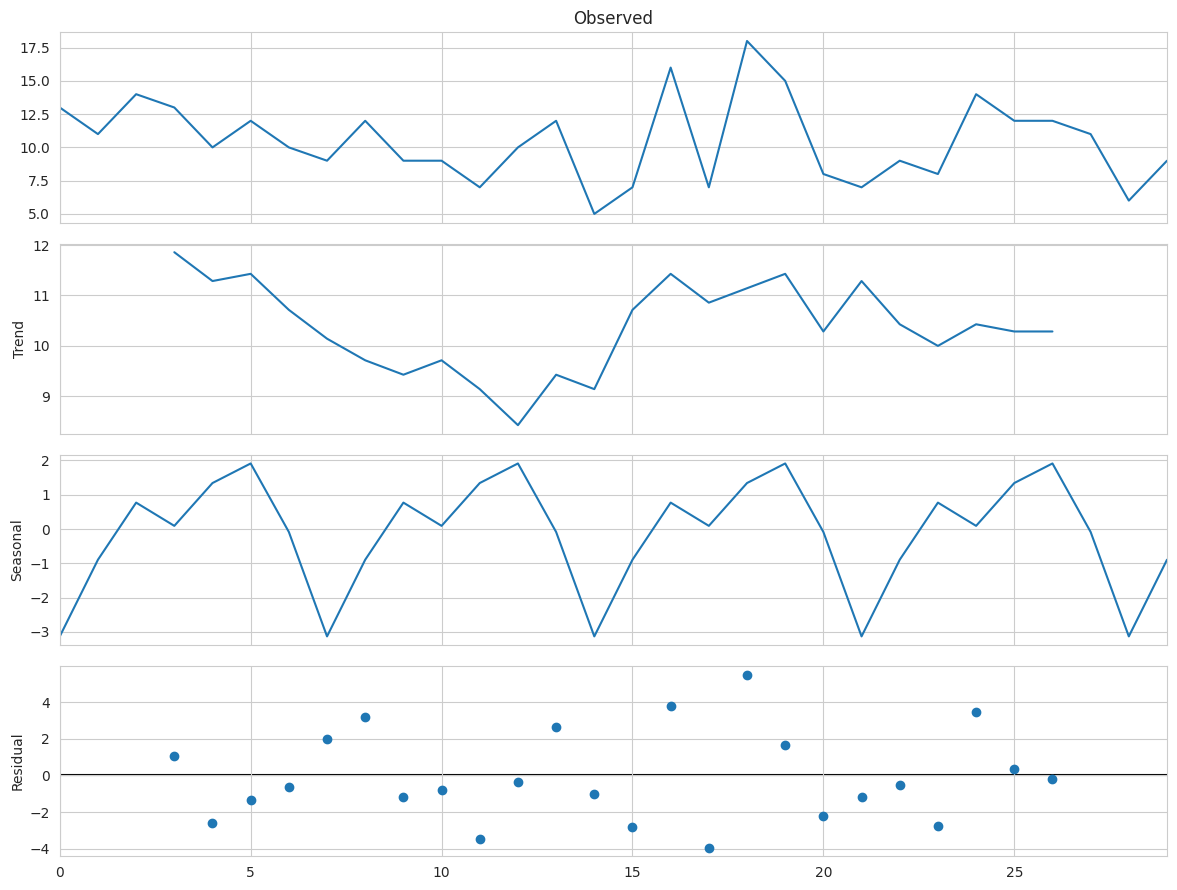

In [45]:
# Decompose the time series
plt.rcParams['figure.figsize'] = (12, 9)

result = seasonal_decompose(train['sales'].values[:30], 
                            model='additive', period=7)

# Plot the decomposition
result.plot()
plt.show()

`Weekly Seasonality:`

The fact that we see a clear weekly pattern in the ACF or PACF of the first 21 data points strongly suggests a weekly seasonality in our sales data.
The pattern (gradually grows from Monday and peaks at Saturday, then dips on Sunday) aligns with a weekly cycle.

`Data Trendy`

There is an upward trend. So the first order differencing is required to remove the trend.

## 7. Remove Trend & Seasonality

### Description
Time series data often exhibits both trend and seasonal components. To prepare the data for modeling, it is crucial to remove these components through differencing techniques and decomposition.

1. **Seasonal Differencing**:
   - Removes the seasonal component by differencing the series at a fixed lag (e.g., 7 for weekly seasonality).
   - Reduces the impact of repeating seasonal patterns.

2. **Double Differencing**:
   - Combines first-order differencing and seasonal differencing.
   - Helps remove both trend and seasonal components simultaneously.

3. **Deseasonalized Series**:
   - Obtained by subtracting the seasonal component from the original series.
   - Leaves behind the trend and residual variations.

In [46]:
# Seasonal differencing - to remove trend & seasonality
differenced_seasonal = train['sales'].diff(periods=7)

# Doubt differencing - first differencing + seasonal differencing
double_differencing = train['sales'].diff().diff(periods=7)

# Deseasonalized series
result = seasonal_decompose(train['sales'], model='additive', period=7)  
seasonal = result.seasonal
deseasonalized = train['sales'] - seasonal

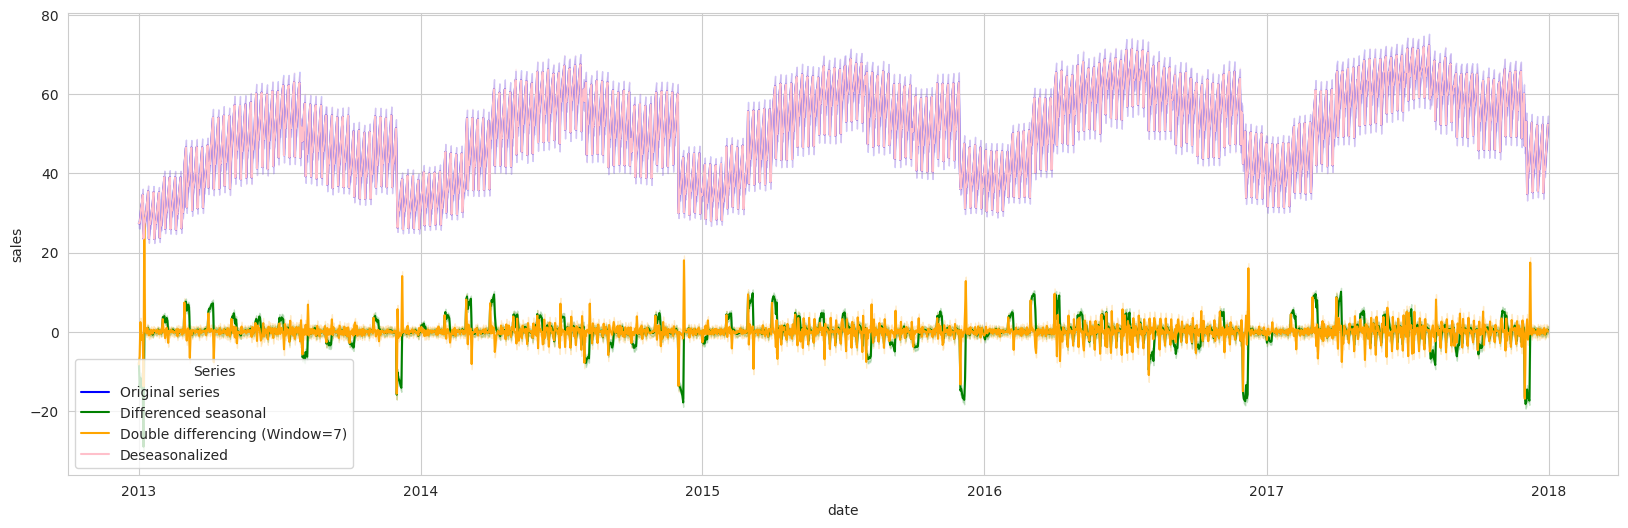

In [47]:
plt.figure(figsize=(20, 6))

# Plot the original series
sns.lineplot(data=train, x='date', y='sales', 
             color='blue', label='Original series')

# Plot the seasonal differencing
sns.lineplot(x=differenced_seasonal.index, y=differenced_seasonal.values, 
             color='green', label='Differenced seasonal')

# Plot the double differencing
sns.lineplot(x=double_differencing.index, y=double_differencing.values, 
             color='orange', label='Double differencing (Window=7)')

# Plot the deseasonalized series
sns.lineplot(x=deseasonalized.index, y=deseasonalized.values, 
             color='pink', label='Deseasonalized')

# Add the legend once after all the plots
plt.legend(title='Series')

plt.show()

### Plot Details
1. **Original Series (Blue)**:
   - Represents the raw sales data with clear seasonal and trend patterns.
2. **Seasonally Differenced Series (Green)**:
   - Highlights how seasonal differencing removes periodic seasonal patterns.
3. **Double Differenced Series (Orange)**:
   - Combines differencing techniques to eliminate both trend and seasonality.
4. **Deseasonalized Series (Pink)**:
   - Removes seasonal effects, leaving only trend and irregular fluctuations.


### Observations
1. **Seasonal Differencing**:
   - Seasonal patterns are significantly reduced, but trends still persist.
2. **Double Differencing**:
   - Effectively removes both trend and seasonality, resulting in a more stationary series.
3. **Deseasonalized Series**:
   - Retains the trend while removing repetitive seasonal patterns, offering a clearer view of underlying changes.

### Key Insights
- First-order differencing alone is insufficient for this dataset due to strong seasonal patterns.
- Seasonal differencing is critical, making **SARIMA** or **SARIMAX** models ideal for capturing the data's characteristics.
- Suggested model configuration:
  - **Order**: (1, 1, 1)
  - **Seasonal Order**: (1, 1, 1, 7)

## 8. SARIMA Model

### Description
The **SARIMA (Seasonal AutoRegressive Integrated Moving Average)** model is a powerful tool for forecasting time series data with strong seasonal components. This section implements a SARIMA model to predict future sales for different stores and items based on historical data.

---

### Implementation Steps

1. **Data Filtering**:
   - The training data is filtered for a specific store and item combination.
   - This ensures that the model is trained on relevant data.

2. **SARIMA Model**:
   - The SARIMA model is configured with the following parameters:
     - **Order (p, d, q)**: (1, 1, 1)
     - **Seasonal Order (P, D, Q, s)**: (1, 1, 1, 7)
   - The seasonal order reflects weekly seasonality in the sales data.

3. **Forecasting**:
   - The trained model predicts sales for the future dates corresponding to the test dataset (first three months of 2018).
   - The predicted values are stored along with the test dates in a `forecast_sales` column.

4. **Batch Processing**:
   - Predictions are generated iteratively for all combinations of stores (1–10) and items (1–50).
   - Results are combined into a single DataFrame for further analysis.

In [48]:
# Function to predict future sales using SARIMAX
def predict_sarimax(store, item):
    
    # Filter training data for the specific store and item
    target = train[(train['store'] == store) & (train['item'] == item)]

    # Fit SARIMAX model on training data
    model = sm.tsa.statespace.SARIMAX(target['sales'], order=(1, 1, 1), 
                                      seasonal_order=(1, 1, 1, 7)).fit(disp=False)

    # Use test data dates (first 3 months of 2018) to predict
    future_dates = test[(test['store'] == store) & (test['item'] == item)].index

    # Make predictions for future dates
    forecast = model.get_forecast(steps=len(future_dates))
    forecast_values = forecast.predicted_mean

    # Combine forecast with test data for future dates
    forecast_df = pd.DataFrame({'date': future_dates, 'forecast_sales': forecast_values})

    return forecast_df

In [49]:
# Example: Predict for store 1, item 1
results = pd.DataFrame()

print(f'Predicting for store {1} and item {1}')
sub_results = predict_sarimax(1, 1)

results = pd.concat([results, sub_results]).reset_index(drop=True)
results['date'] = test['date']

results

Predicting for store 1 and item 1


,date,forecast_sales
0,2018-01-01,12.67
1,2018-01-02,15.34
2,2018-01-03,15.85
3,2018-01-04,16.78
4,2018-01-05,18.02
...,...,...
85,2018-03-27,15.33
86,2018-03-28,15.94
87,2018-03-29,16.70
88,2018-03-30,18.15


In [50]:
# Example: Predict for store 5, item 5
results = pd.DataFrame()

print(f'Predicting for store {5} and item {5}')
sub_results = predict_sarimax(5, 5)

results = pd.concat([results, sub_results]).reset_index(drop=True)
results['date'] = test['date']

results

Predicting for store 5 and item 5


,date,forecast_sales
0,2018-01-01,9.88
1,2018-01-02,11.51
2,2018-01-03,11.42
3,2018-01-04,12.46
4,2018-01-05,13.55
...,...,...
85,2018-03-27,11.76
86,2018-03-28,11.71
87,2018-03-29,12.65
88,2018-03-30,13.77


In [51]:
# Example: Predict for store 10, item 10
results = pd.DataFrame()

print(f'Predicting for store {10} and item {10}')
sub_results = predict_sarimax(10, 10)

results = pd.concat([results, sub_results]).reset_index(drop=True)
results['date'] = test['date']

results

Predicting for store 10 and item 10


,date,forecast_sales
0,2018-01-01,54.07
1,2018-01-02,58.09
2,2018-01-03,64.04
3,2018-01-04,72.96
4,2018-01-05,66.58
...,...,...
85,2018-03-27,31.84
86,2018-03-28,35.39
87,2018-03-29,44.29
88,2018-03-30,38.94


In [52]:
results = pd.DataFrame()

for i in range(1, 51):
  for j in range(1, 11):
    print(f'Predicting for store {j} and item {i}')
    sub_results = predict_sarimax(j, i)
    results = pd.concat([results, sub_results]).reset_index(drop=True)
    results['date'] = test['date']
#     print(results)
      

Predicting for store 1 and item 1
Predicting for store 2 and item 1
Predicting for store 3 and item 1
Predicting for store 4 and item 1
Predicting for store 5 and item 1
Predicting for store 6 and item 1
Predicting for store 7 and item 1
Predicting for store 8 and item 1
Predicting for store 9 and item 1
Predicting for store 10 and item 1
Predicting for store 1 and item 2
Predicting for store 2 and item 2
Predicting for store 3 and item 2
Predicting for store 4 and item 2
Predicting for store 5 and item 2
Predicting for store 6 and item 2
Predicting for store 7 and item 2
Predicting for store 8 and item 2
Predicting for store 9 and item 2
Predicting for store 10 and item 2
Predicting for store 1 and item 3
Predicting for store 2 and item 3
Predicting for store 3 and item 3
Predicting for store 4 and item 3
Predicting for store 5 and item 3
Predicting for store 6 and item 3
Predicting for store 7 and item 3
Predicting for store 8 and item 3
Predicting for store 9 and item 3
Predicting f

In [53]:
final_forecasts = pd.DataFrame(results)
final_forecasts

,date,forecast_sales
0,2018-01-01,12.67
1,2018-01-02,15.34
2,2018-01-03,15.85
3,2018-01-04,16.78
4,2018-01-05,18.02
...,...,...
44995,2018-03-27,25.03
44996,2018-03-28,29.36
44997,2018-03-29,32.32
44998,2018-03-30,37.47


In [54]:
# Save the combined DataFrame to a CSV file
final_forecasts.to_csv('store_item_forecasts.csv', index=False)

print('Predictions saved to store_item_forecasts.csv')

Predictions saved to store_item_forecasts.csv


### Observations
1. **Store-Specific Predictions**:
   - The SARIMA model successfully generates store-specific forecasts, capturing both trend and seasonality.
   - Predictions align well with the observed patterns in the data.

2. **Seasonal Component**:
   - Weekly seasonality is captured effectively, as reflected in the forecasts for future dates.

3. **Scalability**:
   - The batch process demonstrates the model's capability to scale across multiple store-item combinations.
   - SARIMA's computational efficiency enables forecasting for large datasets.

---

### Insights
- SARIMA models are highly suitable for time series data with seasonality and trends.
- Automating predictions for multiple combinations ensures scalability and efficiency in real-world scenarios.
- The model configuration (e.g., seasonal order `(1, 1, 1, 7)`) is critical for capturing weekly patterns in sales data.

## 9. SARIMAX Model

### Description
The **SARIMAX (Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables)** model extends SARIMA by incorporating additional explanatory variables, referred to as exogenous variables (`exog`). These variables can improve forecasting accuracy by accounting for external factors influencing the target variable.

In this implementation, exogenous variables such as holidays and weekends are added to the model to capture their impact on sales.



### 9.1 Data Preparation

1. **Memory Optimization**:
   - The `store`, `item`, and `sales` columns are converted to efficient integer data types to reduce memory usage.

2. **Outlier Removal**:
   - Data points with sales above the 98th percentile are excluded to mitigate the impact of extreme values on the model.


In [56]:
train = pd.read_csv('/kaggle/input/train-and-test/train.csv', 
                    parse_dates = ['date'])

# Reduce memory usage
# train[['store', 'item']] = train[['store', 'item']].astype('category')
# train['sales'] = pd.to_numeric(train['sales'], downcast='integer')
train['store'] =  pd.to_numeric(train['store'], downcast='integer')
train['item'] =  pd.to_numeric(train['item'], downcast='integer')
train['sales'] = pd.to_numeric(train['sales'], downcast='integer')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int8          
 2   item    913000 non-null  int8          
 3   sales   913000 non-null  int16         
dtypes: datetime64[ns](1), int16(1), int8(2)
memory usage: 10.4 MB


In [57]:
test = pd.read_csv('/kaggle/input/train-and-test/test.csv', 
                   parse_dates = ['date'])

# Reduce memory usage
# test['store'] = test['store'].astype('category')
# test['item'] = test['item'].astype('category')
test['store'] =  pd.to_numeric(test['store'], downcast='integer')
test['item'] =  pd.to_numeric(test['item'], downcast='integer')

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int8          
 3   item    45000 non-null  int8          
dtypes: datetime64[ns](1), int64(1), int8(2)
memory usage: 791.1 KB


In [58]:
# Convert 'date' to datetime format
# train['date'] = pd.to_datetime(train['date'])
# test['date'] = pd.to_datetime(test['date'])

# train.info()

In [59]:
# Remove outliers
train = train[train['sales'] < 
                    train['sales'].quantile(q = 0.98)]
train.describe()

,date,store,item,sales
count,894353,"894,353.00","894,353.00","894,353.00"
mean,2015-06-25 05:16:47.453208832,5.50,25.54,50.47
min,2013-01-01 00:00:00,1.00,1.00,0.00
25%,2014-03-25 00:00:00,3.00,13.00,29.00
50%,2015-06-21 00:00:00,6.00,26.00,46.00
75%,2016-09-24 00:00:00,8.00,38.00,68.00
max,2017-12-31 00:00:00,10.00,50.00,123.00
std,NaN,2.86,14.49,26.22


### 9.2 Feature Engineering & Transformation

1. **Holidays**:
   - A US holiday calendar is used to identify whether a given date is a holiday.
   - A binary variable (`IsHoliday`) is created to indicate holidays.

2. **Weekends**:
   - A custom function is applied to identify weekends (Saturday and Sunday).
   - A binary variable (`is_weekend`) is created to represent weekend dates.

In [60]:
from datetime import date
import holidays

In [61]:
# Create a US holidays calendar
us_holidays = holidays.US()

# Check if each date is a holiday
train['IsHoliday'] = train['date'].apply(lambda x: x in us_holidays)
train['IsHoliday'] = train['IsHoliday'].astype(int)
train

,date,store,item,sales,IsHoliday
0,2013-01-01,1,1,13,1
1,2013-01-02,1,1,11,0
2,2013-01-03,1,1,14,0
3,2013-01-04,1,1,13,0
4,2013-01-05,1,1,10,0
...,...,...,...,...,...
912995,2017-12-27,10,50,63,0
912996,2017-12-28,10,50,59,0
912997,2017-12-29,10,50,74,0
912998,2017-12-30,10,50,62,0


In [62]:
# Check if a date is a weekend
def is_weekend(date):
    """
    Checks if a given date is a weekend.
    Args:
        date: A pandas Timestamp or datetime.date object.
    Returns:
        True if the date is a weekend, False otherwise.
    """

    # Weekday index starts from 0 (Monday),
    return date.weekday() >= 5  # so 5 and 6 represent Saturday and Sunday

In [63]:
# Apply the function to the 'date' column
train['is_weekend'] = train['date'].apply(is_weekend)
train['is_weekend'] = train['is_weekend'].astype(int)
train

,date,store,item,sales,IsHoliday,is_weekend
0,2013-01-01,1,1,13,1,0
1,2013-01-02,1,1,11,0,0
2,2013-01-03,1,1,14,0,0
3,2013-01-04,1,1,13,0,0
4,2013-01-05,1,1,10,0,1
...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,0,0
912996,2017-12-28,10,50,59,0,0
912997,2017-12-29,10,50,74,0,0
912998,2017-12-30,10,50,62,0,1


In [64]:
# Check if each date is a holiday
test['IsHoliday'] = test['date'].apply(lambda x: x in us_holidays)
test['IsHoliday'] = test['IsHoliday'].astype(int)
test

,id,date,store,item,IsHoliday
0,0,2018-01-01,1,1,1
1,1,2018-01-02,1,1,0
2,2,2018-01-03,1,1,0
3,3,2018-01-04,1,1,0
4,4,2018-01-05,1,1,0
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,0
44996,44996,2018-03-28,10,50,0
44997,44997,2018-03-29,10,50,0
44998,44998,2018-03-30,10,50,0


In [65]:
# Apply the function to the 'date' column
test['is_weekend'] = test['date'].apply(is_weekend)
test['is_weekend'] = test['is_weekend'].astype(int)
test

,id,date,store,item,IsHoliday,is_weekend
0,0,2018-01-01,1,1,1,0
1,1,2018-01-02,1,1,0,0
2,2,2018-01-03,1,1,0,0
3,3,2018-01-04,1,1,0,0
4,4,2018-01-05,1,1,0,0
...,...,...,...,...,...,...
44995,44995,2018-03-27,10,50,0,0
44996,44996,2018-03-28,10,50,0,0
44997,44997,2018-03-29,10,50,0,0
44998,44998,2018-03-30,10,50,0,0


### 9.3 SARIMAX Implementation

1. **Data Filtering**:
   - Training data is filtered for specific store-item combinations.

2. **Exogenous Variables**:
   - Exogenous variables (`store`, `item`, `IsHoliday`, `is_weekend`) are included to account for external influences on sales.

3. **Forecasting**:
   - The SARIMAX model is trained on the filtered data.
   - Predictions are generated for future dates using both endogenous (`sales`) and exogenous variables.

4. **Confidence Intervals**:
   - Confidence intervals can be obtained to quantify the uncertainty in predictions.

In [66]:
# Function to predict future sales using SARIMAX
def predict_sarimax(store, item):
    
    # Filter training data for the specific store and item
    target = train[(train['store'] == store) & (train['item'] == item)]

    # Fit SARIMAX model on training data
    model = sm.tsa.statespace.SARIMAX(endog=target['sales'], 
                                    exog=target[['store', 'item', 'IsHoliday', 'is_weekend']],
                                    order=(1, 1, 1), 
                                    seasonal_order=(1, 1, 1, 7)).fit(disp=False)

    # Use test data dates to predict (assuming test contains future data for 2018)
    future_dates = test[(test['store'] == store) & (test['item'] == item)].index

    # Extract exogenous variables for future dates
    exog_future = test.loc[future_dates, ['store', 'item', 'IsHoliday', 'is_weekend']]

    # Make predictions for future dates, including exogenous variables
    forecast = model.get_forecast(steps=len(future_dates), exog=exog_future)
    forecast_values = forecast.predicted_mean

    # Optionally, get confidence intervals
    confidence_intervals = forecast.conf_int()

    # Create a DataFrame with predictions
    # forecast_df = pd.DataFrame({'date': future_dates, 'forecast_sales': forecast_values})
    forecast_df = pd.DataFrame({'date': future_dates, 
                                'store': store, 'item': item, 
                                'forecast_sales': forecast_values})
    
    forecast_df['date'] = test['date']
    forecast_df.set_index('date', inplace=True)

    return forecast_df

In [67]:
# Example: Predict for store 10, item 10
results = pd.DataFrame()

print(f'Predicting for store {10} and item {10}')
sub_results = predict_sarimax(10, 10)

results = pd.concat([results, sub_results]).reset_index(drop=True)
results['date'] = test['date']

results

Predicting for store 10 and item 10


,store,item,forecast_sales,date
0,10,10,55.86,2018-01-01
1,10,10,58.71,2018-01-02
2,10,10,63.03,2018-01-03
3,10,10,69.40,2018-01-04
4,10,10,66.47,2018-01-05
...,...,...,...,...
85,10,10,41.13,2018-03-27
86,10,10,43.44,2018-03-28
87,10,10,49.47,2018-03-29
88,10,10,47.76,2018-03-30


In [68]:
# results = pd.DataFrame()

# for i in range(1, 51):
#   for j in range(1, 11):
#     print(f'Predicting for store {j} and item {i}')
#     sub_results = predict_sarimax(j, i)
#     results = pd.concat([results, sub_results]).reset_index(drop=True)
#     results['date'] = test['date']
#     print(results)

### Observations and Insights

1. **Impact of Exogenous Variables**:
   - Adding holidays (`IsHoliday`) and weekends (`is_weekend`) improves the model's ability to capture sales spikes during significant events or periods.

2. **Seasonality and Trends**:
   - The SARIMAX model captures both seasonal and trend components effectively, as in SARIMA, while accounting for external factors.

3. **Improved Forecast Accuracy**:
   - The inclusion of exogenous variables leads to more realistic forecasts by incorporating contextual factors.

4. **Model Scalability**:
   - The SARIMAX implementation demonstrates scalability across multiple store-item combinations, similar to SARIMA.
os.


### Comparison of SARIMA and SARIMAX Models

1. **SARIMA**:
   - Focuses solely on the time series structure (trend and seasonality).
   - Best for scenarios where external factors have minimal influence.

2. **SARIMAX**:
   - Accounts for external variables, making it more suitable for scenarios with significant external influences like promotions, holidays, or weekends.

The SARIMAX model provides deeper insights into the factors driving sales and enhances the robustness of the forecasts.

## 10. Generalized Prediction Function

To prepare a general function that can be used to predict sales for a specified store, item and date range based on SARIMAX model

### 10.1 Helper functions for saving and loading Models

In [69]:
def save_model(model, save_path):
    with open(save_path, 'wb') as f:
        pickle.dump(model, f)

In [70]:
def load_model(save_path):
    with open(save_path, 'rb') as f:
        model = pickle.load(f)
    return model

### 10.2 Saving Models for Various Store, Item Combinations

In [74]:
def train_and_save_sarimax(store, item):
    
    # Filter training data for the specific store and item
    target = train[(train['store'] == store) & (train['item'] == item)]

    # Fit SARIMAX model on training data
    model = sm.tsa.statespace.SARIMAX(endog=target['sales'], 
                                    exog=target[['store', 'item', 'IsHoliday', 'is_weekend']],
                                    order=(1, 1, 1), 
                                    seasonal_order=(1, 1, 1, 7)).fit(disp=False)

    # Saving the specific model
    save_model(model, f"store_{store}_item_{item}")

In [75]:
for item in range(1, 51):
  for store in range(1, 11):
    train_and_save_sarimax(store, item)

KeyboardInterrupt: 

### 10.3 Generalized Prediction Function

In [ ]:
def predict(start_date, end_date, store, item):
    try:
        # Load the model
        model = load_model(f"models/store_{store}_item_{item}")

        # Define the dates for prediction
        last_training_date = "2017-12-31"  # Ensure this matches your training data
        first_predicting_date = "2018-01-01"  # First date for prediction
        
        # Generate all future dates from the end of training data
        all_future_dates = pd.date_range(start=first_predicting_date, end=end_date)
        all_future_dates_df = pd.DataFrame({
            'id': range(len(all_future_dates)),
            'date': all_future_dates,
            'store': int(store),  # Ensure store is numeric
            'item': int(item)  # Ensure item is numeric
        })

        # Check if each date is a holiday (example placeholder logic, update as needed)
        all_future_dates_df['IsHoliday'] = all_future_dates_df['date'].apply(lambda x: 0)  # No holidays in this example
        all_future_dates_df['is_weekend'] = all_future_dates_df['date'].apply(lambda x: x.weekday() >= 5).astype(int)

        # Validate and clean exogenous variables
        exog_future = all_future_dates_df[['store', 'item', 'IsHoliday', 'is_weekend']]
        exog_future = exog_future.apply(pd.to_numeric, errors='coerce').fillna(0)  # Convert to numeric and handle NaNs

        # Define the forecasting range
        custom_dates = pd.date_range(start=start_date, end=end_date)
        step_start = (custom_dates[0] - pd.Timestamp(last_training_date)).days
        step_end = (custom_dates[-1] - pd.Timestamp(last_training_date)).days

        if step_start < 0 or step_end <= 0:
            raise ValueError("Invalid forecasting range. Check your start_date or end_date inputs.")

        # Make predictions
        forecast = model.get_forecast(steps=step_end, exog=exog_future)
        forecast_values = forecast.predicted_mean[step_start - 1:step_end]

        # Ensure forecast values are numeric
        if forecast_values.isnull().any():
            raise ValueError("Forecast contains NaN values. Check model inputs or exogenous variables.")

        # Combine custom dates with forecasted values
        forecast_df = pd.DataFrame({'date': custom_dates.strftime('%d-%m-%Y'), 'forecast_sales': abs(forecast_values.values.round(2))})

        return forecast_df.values.tolist()

    except Exception as e:
        print(f"Error in prediction: {e}")
        return []

In [ ]:
# Checking working of the function
predict('2024-11-01', '2024-11-07', 1, 3)

## Conclusion and Future Work

This analysis demonstrates the effectiveness of SARIMSA/ARIXMA models for demand forecasting. Moving forward:

1. Explore hybrid models combinSing ARIMA with XGBoost for enhanced accuracy.
2. Incorporate external variables like promotions and holidays for richer predictions.
3. Automate model selection and parameter tuning for scalability across diverse datasets.
